In [24]:
# 1: Libraries
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, MinMaxScaler, StandardScaler

%matplotlib inline

In [25]:
# -------------------------
# 2: Data loading
# -------------------------
def load_data(path="Talent_Academy_Case_DT_2025.xlsx"):
    df = pd.read_excel(path)
    print(f"Veri yüklendi: {df.shape[0]} satır, {df.shape[1]} kolon")
    return df

df = load_data()

Veri yüklendi: 2235 satır, 13 kolon



Veri tipleri:
HastaNo             int64
Yas                 int64
Cinsiyet           object
KanGrubu           object
Uyruk              object
KronikHastalik     object
Bolum              object
Alerji             object
Tanilar            object
TedaviAdi          object
TedaviSuresi       object
UygulamaYerleri    object
UygulamaSuresi     object
dtype: object

Eksik değerler:
HastaNo              0
Yas                  0
Cinsiyet           169
KanGrubu           675
Uyruk                0
KronikHastalik     611
Bolum               11
Alerji             944
Tanilar             75
TedaviAdi            0
TedaviSuresi         0
UygulamaYerleri    221
UygulamaSuresi       0
dtype: int64

Duplicate satır sayısı: 928

Temel istatistikler:
              HastaNo          Yas Cinsiyet KanGrubu    Uyruk  \
count     2235.000000  2235.000000     2066     1560     2235   
unique            NaN          NaN        2        8        5   
top               NaN          NaN    Kadın    0 Rh+  Türk

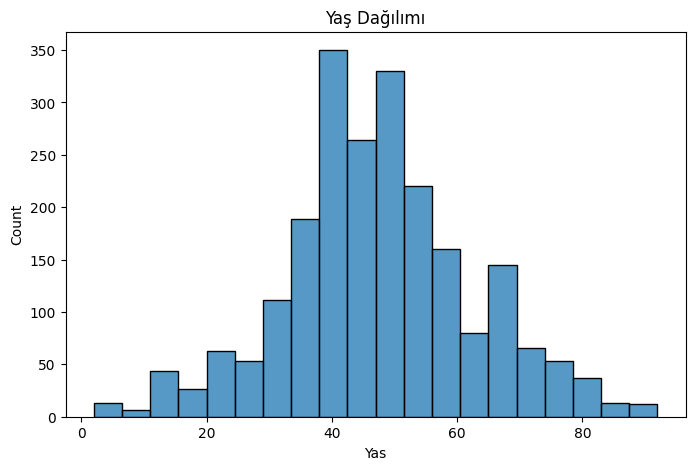

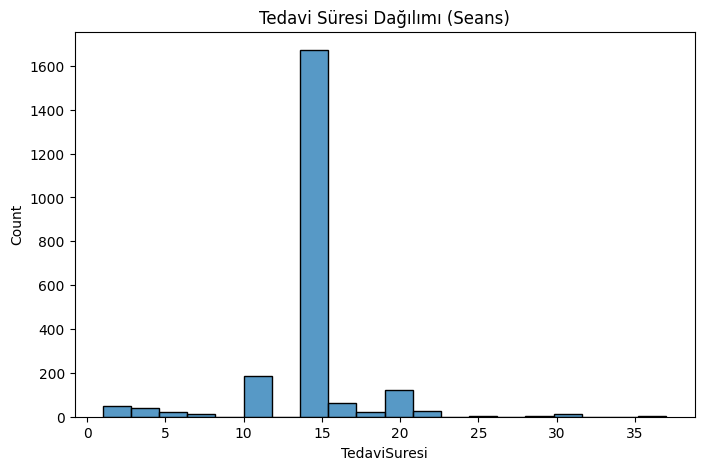

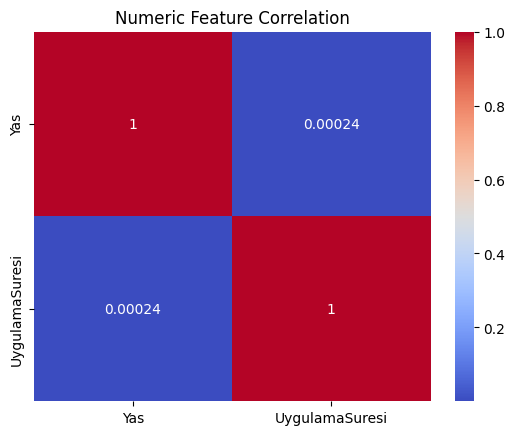

In [26]:
#  3: EDA
# -------------------------
def basic_eda(df):
    print("\nVeri tipleri:")
    print(df.dtypes)
    
    print("\nEksik değerler:")
    print(df.isnull().sum())
    
    print(f"\nDuplicate satır sayısı: {df.duplicated().sum()}")
    
    print("\nTemel istatistikler:")
    print(df.describe(include='all'))
    
    # Histogramlar
    plt.figure(figsize=(8,5))
    sns.histplot(df['Yas'], bins=20)
    plt.title("Yaş Dağılımı")
    plt.show()
    
    plt.figure(figsize=(8,5))
    sns.histplot(df['TedaviSuresi'].apply(lambda x: int(str(x).split()[0])), bins=20)
    plt.title("Tedavi Süresi Dağılımı (Seans)")
    plt.show()
    
    # Korelasyon heatmap
    numeric_cols = ['Yas','UygulamaSuresi']
    df_numeric = df.copy()
    df_numeric['UygulamaSuresi'] = pd.to_numeric(df_numeric['UygulamaSuresi'].str.extract('(\d+)')[0], errors='coerce')
    sns.heatmap(df_numeric[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title("Numeric Feature Correlation")
    plt.show()

basic_eda(df)

In [27]:
# 4: Multi-label frecuency
# -------------------------
def multi_label_frequency(df):
    mlb_cols = ['KronikHastalik','Alerji','Tanilar','UygulamaYerleri']
    for col in mlb_cols:
        all_items = df[col].dropna().apply(lambda x: [i.strip() for i in str(x).split(',')]).explode()
        freq = all_items.value_counts().head(10)
        print(f"\nTop 10 {col} values:")
        print(freq)

multi_label_frequency(df)


Top 10 KronikHastalik values:
KronikHastalik
Aritmi                           395
Hiportiroidizm                   383
Limb-Girdle Musküler Distrofi    379
Astım                            351
Hipertiroidizm                   327
Myastenia gravis                 316
Diyabet                          308
Duchenne Musküler Distrofisi     307
Fascioscapulohumeral Distrofi    304
Kalp yetmezliği                  301
Name: count, dtype: int64

Top 10 Alerji values:
Alerji
Polen          330
POLEN          170
Toz            138
TOZ            121
NOVALGIN       110
ARVELES        102
CORASPIN       102
Sucuk           96
Yer Fıstığı     83
SUCUK           78
Name: count, dtype: int64

Top 10 Tanilar values:
Tanilar
DORSALJİ                            695
DİĞER                               676
tanımlanmamış                       408
Omuzun darbe sendromu               272
İntervertebral disk bozuklukları    269
LUMBOSAKRAL BÖLGE                   265
SERVİKOTORASİK BÖLGE                211


In [28]:
# Hücre 5: Remove Duplicate
# -------------------------
def remove_duplicates(df):
    print(f"Duplicate sayısı: {df.duplicated().sum()}")
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Duplicate sonrası satır sayısı: {df.shape[0]}")
    return df

df = remove_duplicates(df)

Duplicate sayısı: 928
Duplicate sonrası satır sayısı: 1307


In [29]:
# 6: Fill Missing Values
# -------------------------
def fill_missing_values(df):
    # Sayısal kolonlar
    num_cols = ['Yas']
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Kategorik kolonlar
    cat_cols = ['Cinsiyet','KanGrubu','Uyruk','Bolum']
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # Multi-label kolonlar için boş string
    mlb_cols = ['KronikHastalik','Alerji','Tanilar','UygulamaYerleri']
    for col in mlb_cols:
        df[col] = df[col].fillna('')
    
    return df

df = fill_missing_values(df)

In [30]:
# 7: Encoding
# -------------------------
def encode_features(df):
    # OneHotEncoding
    ohe_cols = ['Cinsiyet','KanGrubu','Uyruk','Bolum','TedaviAdi']
    ohe = OneHotEncoder(sparse_output=False)
    encoded = ohe.fit_transform(df[ohe_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(ohe_cols))
    df = pd.concat([df.drop(columns=ohe_cols).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

    # Multi-label kolonları encode etme
    mlb_cols = ['KronikHastalik','Alerji','Tanilar','UygulamaYerleri']
    for col in mlb_cols:
        mlb = MultiLabelBinarizer()
        split_col = df[col].apply(lambda x: [i.strip() for i in x.split(',')] if x != '' else [])
        encoded_multi = mlb.fit_transform(split_col)
        encoded_multi_df = pd.DataFrame(encoded_multi, columns=[f"{col}_{c}" for c in mlb.classes_])
        df = pd.concat([df.drop(columns=[col]), encoded_multi_df], axis=1)
    
    return df

df = encode_features(df)

In [31]:
# 8: Convert Numeric 
# -------------------------
def convert_numeric(df):
    df['TedaviSuresi'] = df['TedaviSuresi'].str.extract('(\d+)').astype(int)
    df['UygulamaSuresi'] = df['UygulamaSuresi'].str.extract('(\d+)').astype(int)
    return df

df = convert_numeric(df)

In [32]:
# 9: Feature Engineering
# -------------------------
def feature_engineering(df):
    bins = [0,30,50,70,100]
    labels = ['Genç','Orta Yaş','Yaşlı','Çok Yaşlı']
    df['Yas_Grubu'] = pd.cut(df['Yas'], bins=bins, labels=labels)
    return df

df = feature_engineering(df)

In [33]:
# 10: Additional Features
# -------------------------
def additional_features(df):
    df['UygulamaSuresi_per_Seans'] = df['UygulamaSuresi'] / df['TedaviSuresi']
    return df

df = additional_features(df)

In [34]:
# 11: Normalization / Scaling
# -------------------------
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df, cols=['Yas', 'UygulamaSuresi', 'UygulamaSuresi_per_Seans']):
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

df = normalize_features(df)



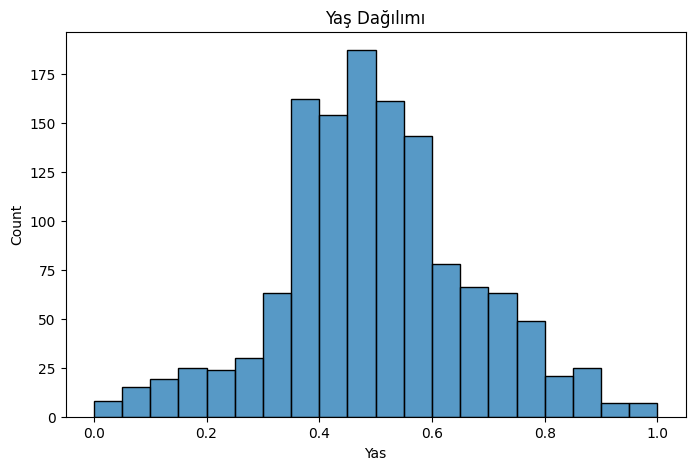

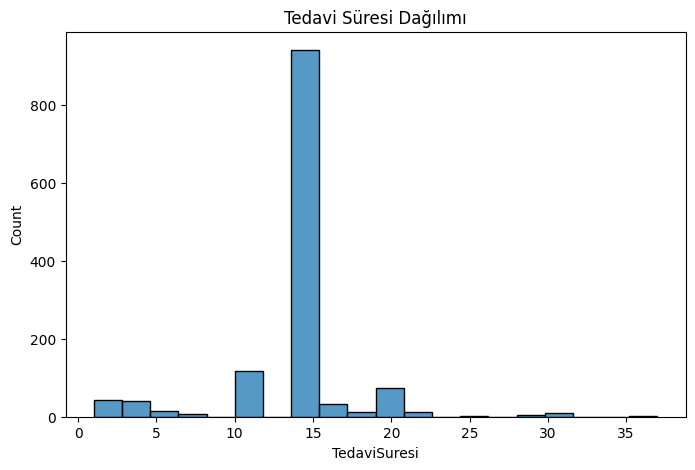

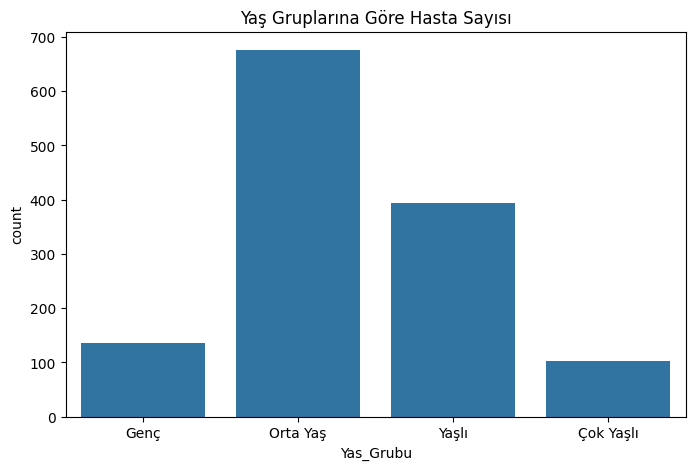

In [35]:
# 12: Plots
# -------------------------
def plot_histograms(df):
    plt.figure(figsize=(8,5))
    sns.histplot(df['Yas'], bins=20)
    plt.title("Yaş Dağılımı")
    plt.show()

    plt.figure(figsize=(8,5))
    sns.histplot(df['TedaviSuresi'], bins=20)
    plt.title("Tedavi Süresi Dağılımı")
    plt.show()

    plt.figure(figsize=(8,5))
    sns.countplot(x='Yas_Grubu', data=df)
    plt.title("Yaş Gruplarına Göre Hasta Sayısı")
    plt.show()

plot_histograms(df)

In [ ]:
# 13: Save Cleaned Data
# -------------------------
def save_cleaned_data(df, path="cleaned_data.csv"):
    df.to_csv(path, index=False)
    print(f"Temizlenmiş veri kaydedildi: {path}")

save_cleaned_data(df)

Temizlenmiş veri kaydedildi: cleaned_data.csv
